# Bank Churn Prediction

## Background
Businesses like banks that provide services have to worry about the problem of 'churn', which is customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can then concentrate efforts on improvement of service, keeping in mind these priorities.

## Objective
Given a bank customer, build a neural network based classifier that can determine whether they will leave or not in the next 6 months.

## Data  Description
The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore,
Geography, Gender, Age, Tenure, and Balance.

(this notebook loaded to GitHub at https://github.com/GreatLearningAIML1/gl-pgp-aiml-uta-intl-may20-pierssmith/tree/master/Week%2019%20-%20Project%20-%20Neural%20Networks)

#  
---
# 1 - Import libraries
---

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

sns.reset_orig()

#  
---
# 2 - Deliverables
---

### Deliverable 1. Read the dataset 

In [2]:
df_abt_CustomerData = pd.read_csv('bank.csv')

In [3]:
df_abt_CustomerData.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [4]:
df_abt_CustomerData.tail()

RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000    15628319     Walker          792    France  Female   28   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
9995       5       0.00              2          1               0   
9996      10   57369.61              1          1               1   
9997       7       0.00              1          0               1   
9998       3   75075.31              2          1               0   
9999       4  130142.79              1          1               0   

      EstimatedSalary  Exited  
9995         96270.64       0  
9996        101699.77       0  
9997         42085.58       1  
9998         92888.52       1  
9999         38190.78       0

In [5]:
df_abt_CustomerData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


#### Data load summary

The dataset contains the expected 10,000 observations as was disclosed in the data description. There are 14 columns, with three loaded as categorical variables (Surname, Geography, and Gender) and the remaining loaded as numeric. There are no null values.

---
## Exploratory Data Analysis
---

### Profiling Report

In [6]:
pandas_profiling.ProfileReport(df_abt_CustomerData)

###  
### Deliverable 2. Drop the columns which are unique for all users like IDs
---

The columns RowNumber and CustomerId are indexes/unique identifiers (all 10000 observations are unique) so will be dropped. The Surname field is not unique although it has high cardinality (2.932 distinct values), but more importantly a customer's Surname is not likely to be a useful predictor of whether they will churn, so this field will be dropped as well.

In [7]:
df_abt_CustomerData.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [8]:
df_abt_CustomerData.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0

###  
### Deliverable 3. Distinguish the features and target variable
---

The 11 remaining columns are CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary and Exited.

The Exited column appears to be the target variable - it describes the behaviour that is being targeted for this analysis ("churn" is customers leaving/exiting the bank for another provider), and the data is in boolean form with no nulls.

It is of note that there is another boolean variable called IsActiveMember, which could at face value be referring to the customer's status with the bank, based on it's name. However inspecting the variable's interaction with the Exited variable (there are some customers who have a "true" value for IsActiveMember, but also a "true" for having Exited) suggests that in fact this variable is a measure of how engaged the customer is with the banks products - i.e. that they are an "active" user.

So, Exited is the target variable, which gives us 10 features.

### Feature analysis

#### CreditScore

In [9]:
df_abt_CustomerData['CreditScore'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64

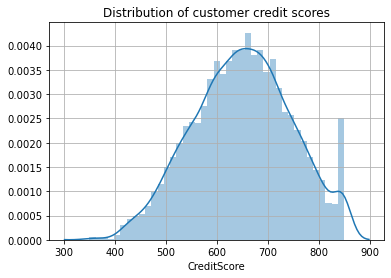

In [10]:
g1 = sns.distplot(df_abt_CustomerData['CreditScore'])
g1.grid()
g1.set(title='Distribution of customer credit scores')
plt.show()

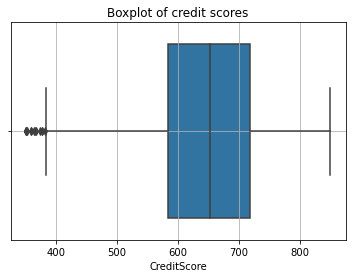

In [11]:
g1 = sns.boxplot(df_abt_CustomerData['CreditScore'])
g1.grid()
g1.set(title='Boxplot of credit scores')
plt.show()

A credit score is a rating of creditworthiness, issued by a rating agency and then used by providers of financial products to assess risk when dealing with a customer. Examining the data in this set, the scores appear to be FICO scores - FICO scores range from 300-850, and the observations in this dataset range from 350-850. Higher scores are better, and indicate customers with a better credit history. FICO scores also measure how actively a customer uses credit products, so this is a very relevant variable to understand customer behaviour and how it predicts churn.

Although FICO scores are integers in a continuous range from 300-850, they tend to be used to classify poor, fair, good, and excellent. However, there is no real agreement between rating agencies or credit providers as to what these ranges are. In the absence of this bank's own policy for classifying credit scores, this variable will be used in it's numeric form for this analysis.

The distribution of credit ratings looks normal, with a slight left skew. There are a handful of observations outside the whiskers, however they are grouped closely and are not significantly outside the whiskers. Noting also there are other strategies that can be used with DNN and I would rather not lose the data, the observations will be kept.

#### Geography

In [12]:
df_abt_CustomerData['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

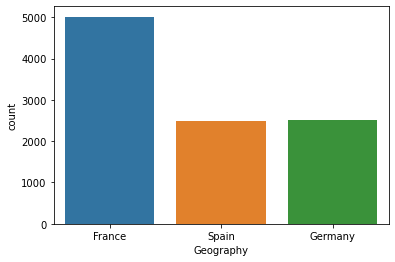

In [13]:
sns.countplot(x='Geography', data=df_abt_CustomerData)
plt.xlabel('Geography')
plt.show()

Geography is a categorical variable, and three categories are present in the data (again with no nulls) - France, Spain, and Germany. Approximately half the customers are in France, with the other half divided approximately evenly between Spain and Germany. Customer location, and therefore proximity to different services offered by the bank, could certainly be an indicator of churn, so this feature will be used. As it is categorical, this will be one-hot encoded before being used.

#### Gender

In [14]:
df_abt_CustomerData['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

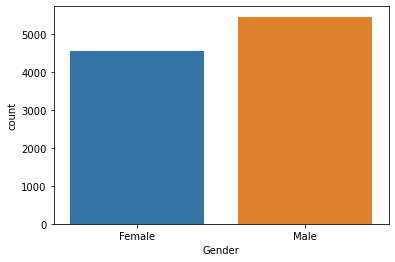

In [15]:
sns.countplot(x='Gender', data=df_abt_CustomerData)
plt.xlabel('Gender')
plt.show()

Gender is also a categorical variable, and in this dataset is a binary classification between male and female. In this customer group, the gender split is approximately 55% male to 45% female. Gender may also be a predictor of churn depending on how the bank designs and markets its products, so this feature will be used. Again, as a categorical variable, it will be one-hot encoded before use.

#### Age

In [16]:
df_abt_CustomerData['Age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: Age, dtype: float64

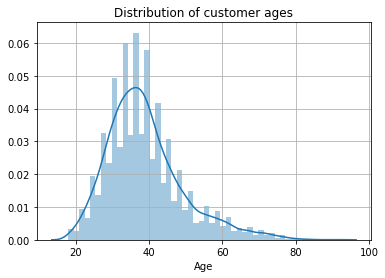

In [17]:
g1 = sns.distplot(df_abt_CustomerData['Age'])
g1.grid()
g1.set(title='Distribution of customer ages')
plt.show()

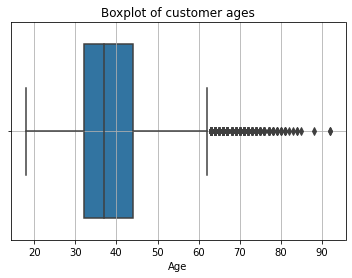

In [18]:
g1 = sns.boxplot(df_abt_CustomerData['Age'])
g1.grid()
g1.set(title='Boxplot of customer ages')
plt.show()

Customer ages in this dataset are in a range from 18 to 92, with an average age of approximately 39 and a standard deviation of 10.4 years. With a median age of 37 and a Q3 age of 44, the distribution is highly right skewed (skewness 1.01), with a number of outliers at the top of the age range. The range looks to be realistic in terms of actual life expectancy (max of 92) and the age at which people can become customers in their own right (18), so with there also being no null values no imputation is required.

Noting the skewness, the data will be retained for the first pass of model building, as there are other strategies for DNN (such as increasing the depth) that can make the model more robust to outliers. Also, it's clear from the boxplot that dropping all the outliers will result in a large data loss. Accordingly, dropping the outliers and testing this dataset in one of iterations will be considered as a strategy option for improving the performance of the model later.

#### Tenure

In [19]:
df_abt_CustomerData['Tenure'].describe()

count    10000.000000
mean         5.012800
std          2.892174
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: Tenure, dtype: float64

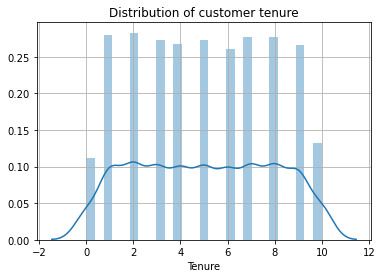

In [20]:
g1 = sns.distplot(df_abt_CustomerData['Tenure'])
g1.grid()
g1.set(title='Distribution of customer tenure')
plt.show()

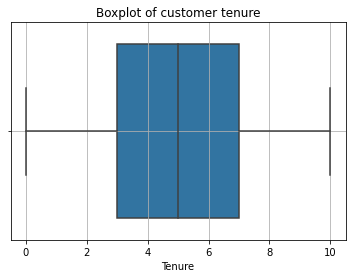

In [21]:
g1 = sns.boxplot(df_abt_CustomerData['Tenure'])
g1.grid()
g1.set(title='Boxplot of customer tenure')
plt.show()

From the name of the variable, Tenure refers to the length of time that the customer has been with the bank. The range is 0 to 10, which suggests the scale is in years. The distribution is normal, with the mean and median both at 5 years and a standard deviation of 2.89. It's interesting that despite the outliers observed in customer ages (the oldest customer being 92), that no customers in this dataset have been with the bank for longer than 10 years. A 2019 study by Accenture of global financial service consumer habits suggests that even skeptical customers stay with their bank for 14 years on average - that suggests that either this dataset has been deliberately limited by the client to customers who have been with the bank for 10 years or less (which may explain the more or less even distribution), or that the bank has an historical issue with churn. Either way, this is an important qualification to the results.

#### Balance

In [22]:
df_abt_CustomerData['Balance'].describe()

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: Balance, dtype: float64

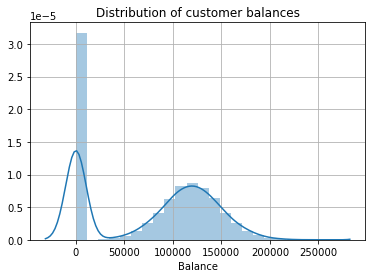

In [23]:
g1 = sns.distplot(df_abt_CustomerData['Balance'])
g1.grid()
g1.set(title='Distribution of customer balances')
plt.show()

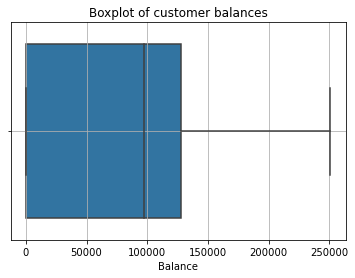

In [24]:
g1 = sns.boxplot(df_abt_CustomerData['Balance'])
g1.grid()
g1.set(title='Boxplot of customer balances')
plt.show()

The Balance variable appears to capture the total balance the customer has on deposit with the bank - there are two related variables NumOfProducts and HasCrCard which would then capture how this relates to product usage.

Balance is in a range from 0 to 250898.09, with an average of 76485.88 and a standard deviation of 62397.40. This means that despite the high number of zeros in the observation (36.2%), the skewness is still low (-0.14) - this can also be observed in the boxplot, where there are no observations outside the whiskers. Interestingly, despite the presence of credit products in the dataset (the HasCrCard variable), there are no negative balances. The amount on deposit a customer has with a bank may be a predictor of churn, as a customer with no deposits and a zero balance has no real ties to the bank, so this variable will be retained.

#### NumOfProducts

In [25]:
df_abt_CustomerData['NumOfProducts'].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

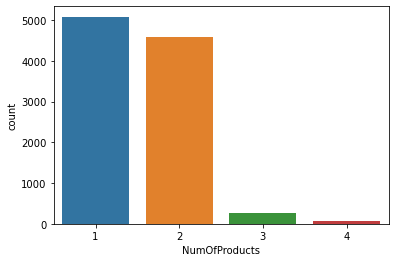

In [26]:
sns.countplot(x='NumOfProducts', data=df_abt_CustomerData)
plt.xlabel('NumOfProducts')
plt.show()

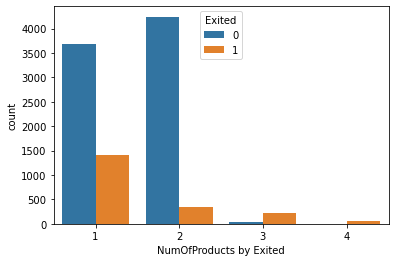

In [27]:
sns.countplot(x = "NumOfProducts", hue="Exited", data = df_abt_CustomerData)
plt.xlabel('NumOfProducts by Exited')
plt.show()

NumOfProducts, based on its name and the context for this dataset, is a count of the different banking products used by the customer (which could include cheque accounts, or term deposits) - noting however that no customers have negative balances, which suggests this sample does not include customers with liability accounts (such as loans) with the bank.

The range for this variable is 1 to 4, however out of 10,000 observations there are only 326 (3.26%) that have more than 2 products. The means 96.74% of the customers in the dataset have only 1 or 2 products. On the one hand, this might suggest this variable may be a candidate for being dropped, as there would appear to be very little difference in terms of engagement with the bank's products when customers only use 1 or 2 of them, and this covers nearly all of the observations. On the other hand, all 60 customers with 4 products ended up churning, so although it's a small number of observations it would appear to still have some predictive value. This will be considered in the performance improvement options below.

#### HasCrCard

In [28]:
df_abt_CustomerData['HasCrCard'].value_counts()

1    7055
0    2945
Name: HasCrCard, dtype: int64

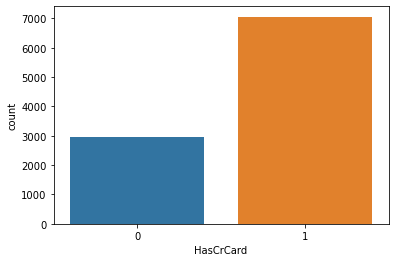

In [29]:
sns.countplot(x='HasCrCard', data=df_abt_CustomerData)
plt.xlabel('HasCrCard')
plt.show()

HasCrCard, given the name and context, would appear to refer to whether the customer has a credit card. The data is in boolean form, with approximately 70% of customers having a credit card.

This variable would appear to be subordinate to the NumOfProducts variable (a credit card is a banking product, so this variable is potentially a subset of the NumOfProducts variable). 

Of note also is that no customers in this dataset have a negative balance, so although they may have a credit card, none of them are carrying a credit balance - this suggests a different type of usage (i.e. balances always paid in full each month). Given the entire dataset has no negative balances, that pattern of usage covers all observations. 

Also, the previous variable NumOfProducts has been flagged as one to potentially drop from the dataset, to test the impact on the predictive performance of the model. As it is appears that HasCrCard is a subset of NumOfProducts, in the candidate dataset for testing the effect of features on the model this variable will be dropped as well.

#### IsActiveMember

In [30]:
df_abt_CustomerData['IsActiveMember'].value_counts()

1    5151
0    4849
Name: IsActiveMember, dtype: int64

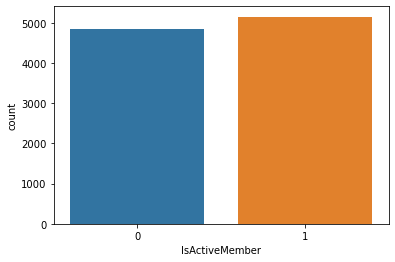

In [31]:
sns.countplot(x='IsActiveMember', data=df_abt_CustomerData)
plt.xlabel('IsActiveMember')
plt.show()

As discussed above in the analysis to separate the target variable from the independent variables, the IsActiveMember variable appears to capture whether the customer is an "active" user of the bank's services. The observations are in boolean form, and there are no nulls.

However, without the criteria by which "active" is judged, this variable is difficult to assess. As there are no customers with zero banking products (as above in the analysis of NumOfProducts, there are no customers with 0 products) "active" cannot be a reference to product ownership, but must be a reference to either frequency of use, or perhaps the last time a customer used their product. The variable also appears to divide the dataset nearly perfectly in half, with 51.5% of customers being "active", and 48.5% of customers being not active. Without knowledge of the criteria it's difficult to assess the usefulness of this criteria as a predictor of churn - this will be examined in bivariate analysis.

#### EstimatedSalary

In [32]:
df_abt_CustomerData['EstimatedSalary'].describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: EstimatedSalary, dtype: float64

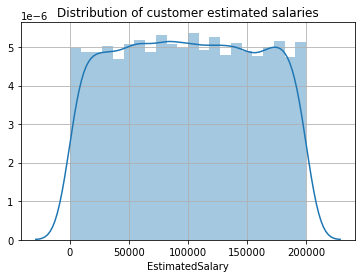

In [33]:
g1 = sns.distplot(df_abt_CustomerData['EstimatedSalary'])
g1.grid()
g1.set(title='Distribution of customer estimated salaries')
plt.show()

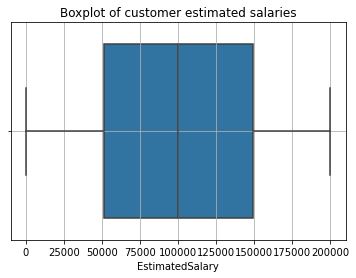

In [34]:
g1 = sns.boxplot(df_abt_CustomerData['EstimatedSalary'])
g1.grid()
g1.set(title='Boxplot of customer estimated salaries')
plt.show()

EstimatedSalary is, based on it's name, not a datapoint collected from an actual observation, but an estimate based on some sort of observation about the customer, their circumstances, or perhaps their banking usage. 

Based on it's almost perfectly even distribution (e.g. mean 100090 and median 100193, skewness 0.002), the value appears to be imputed based on a set of rules. Without knowledge of how this observation is imputed, it's difficult to assert that it will be a good predictor of churn - if the process by which the salary is estimated is flawed, then the model that uses it to predict churn will also be flawed. 

Of note also is that the range and scale of this variable is problematic - the observations range from 11.58 to 199992.48, and the scale and timeframe is not given. If the scale is dollars and the timeframe is annual, then a salary of \\$11.58 does not make sense. If the scale is hundreds and timeframe is annual, then the low end salary is still only \\$1,158, but the maximum salary has now become nearly \\$20m and the average customer makes \\$10m. In fact, with a range of 11.58 to 199,992.48 there's no obvious combination of scale and timeframe by which this variable can be interpreted in a way that makes sense.

There are no outliers in this distribution as noted above, so adjustments to make the range intuitively fit the variable are going to be completely subjective. The effect of this variable will be observed in the bivariate analysis, but this variable is also a good candidate to be dropped when examining the effect of feature selection on the model performance.

### Target Variable

#### Exited

In [35]:
df_abt_CustomerData['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

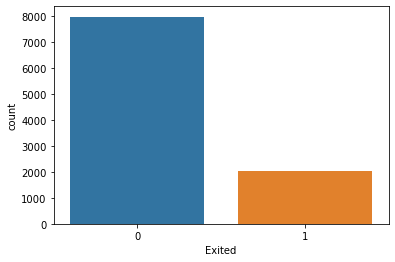

In [36]:
sns.countplot(x='Exited', data=df_abt_CustomerData)
plt.xlabel('Exited')
plt.show()

The dataset contains far fewer "true" observation (1 - i.e., customer has exited) than it does for the "false" case. 

The imbalance is approximately 80% (negative) to 20% (positive), meaning that for this group of customers, 80% of them have not churned and are still customers, and only 20% have churned. This imbalance may need to be addressed in the model fitting.

### Bivariate Analysis

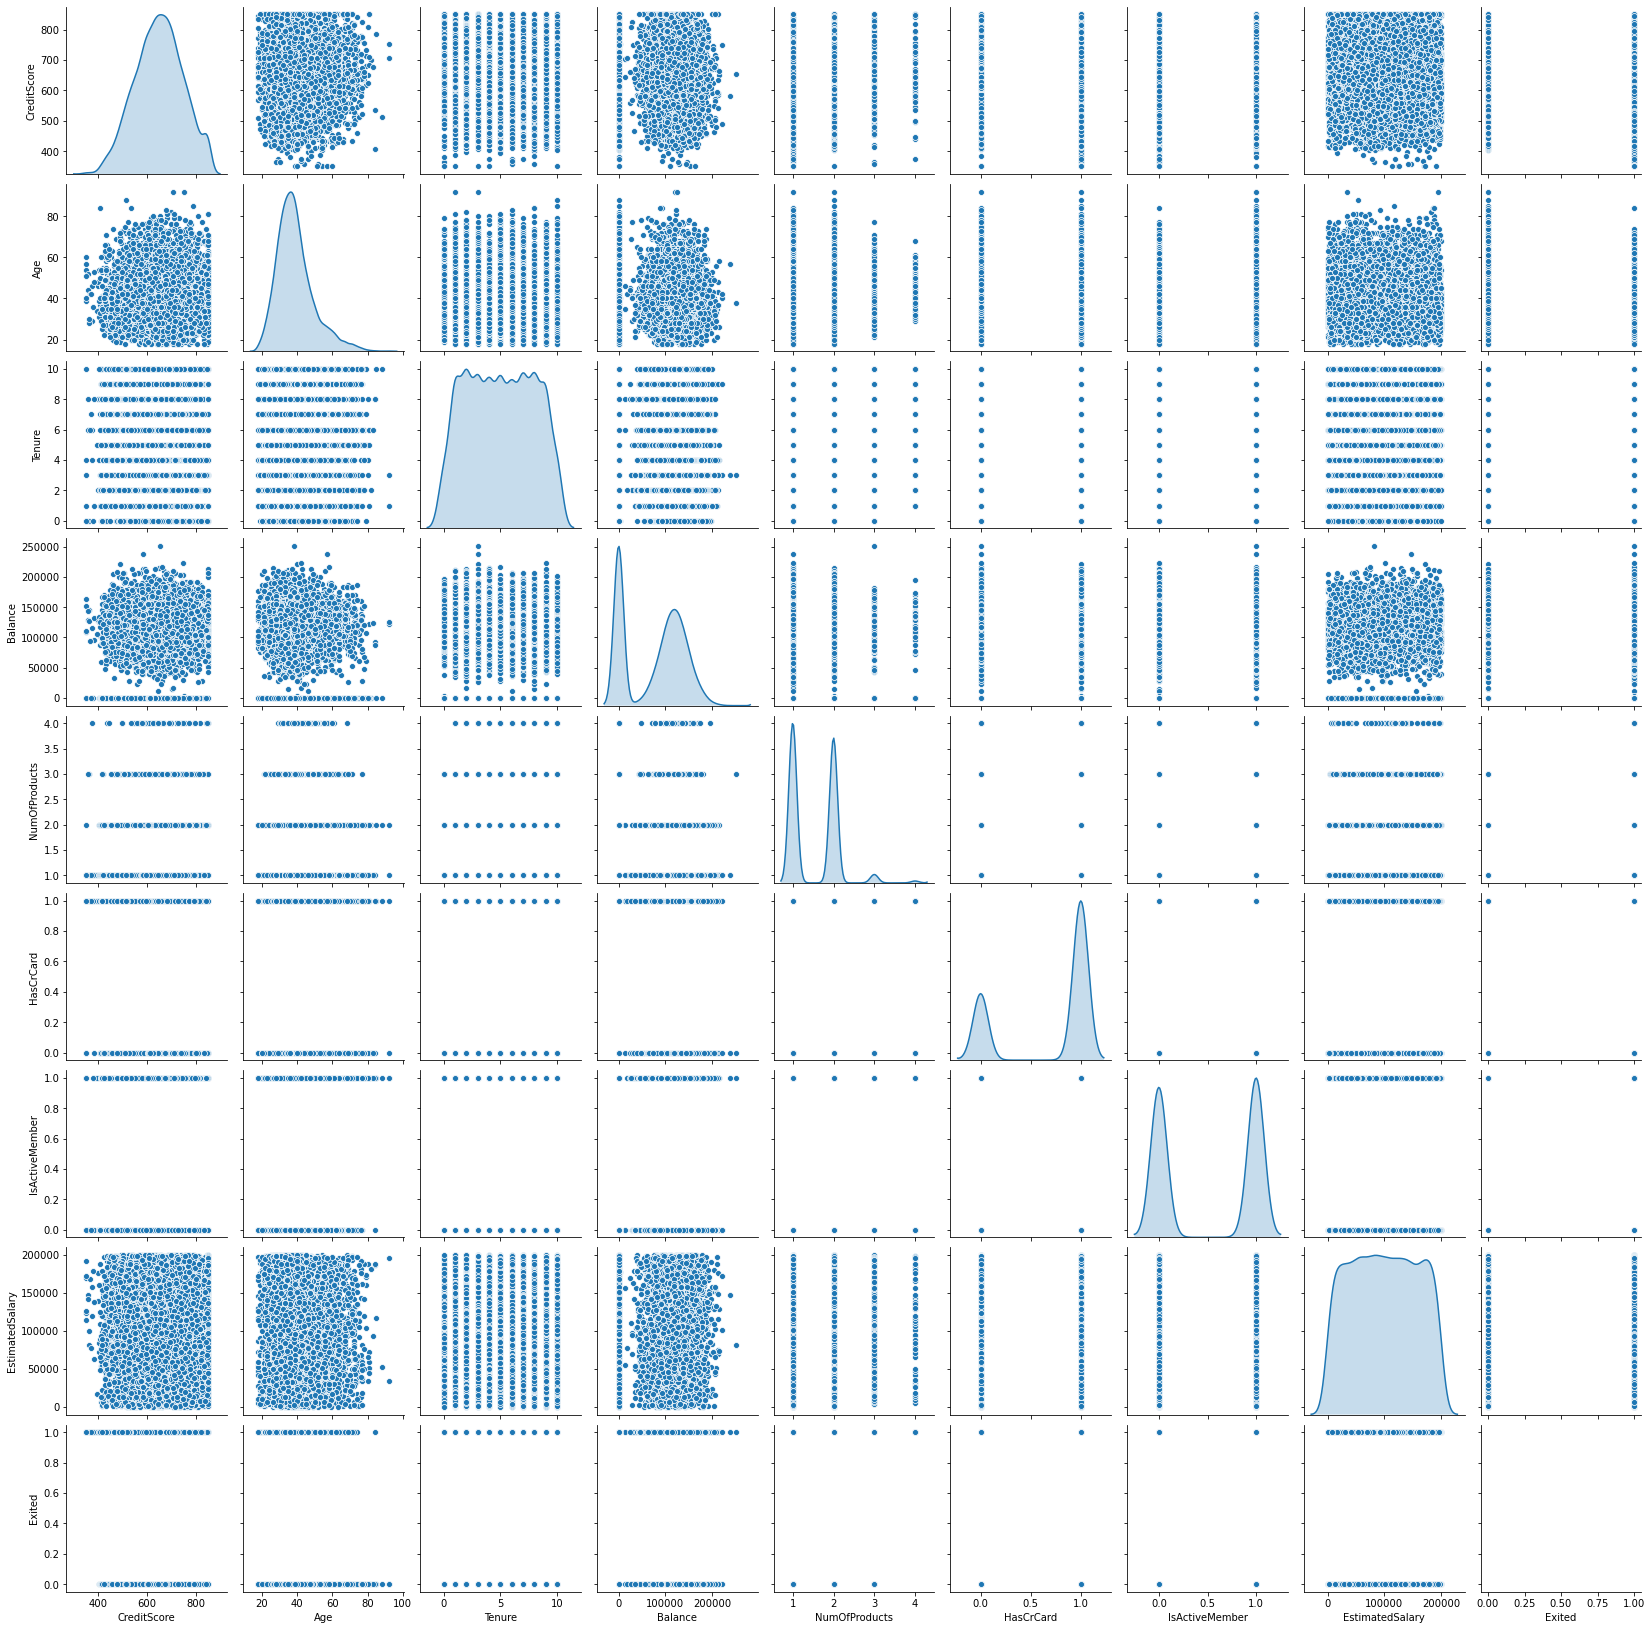

In [37]:
sns.pairplot(df_abt_CustomerData, diag_kind='kde');

There are no obvious linear relationships between the continuous independent variables, and other than the uniquely predictive ownership of 4 products that was noted above, none of the independent variables shown an obvious predictive relationship to the target variable. The continuous variables (credit score, age, balance, and estimated salary) show exits and non-exits across their entire range. The correlation matrix below demonstrates this.

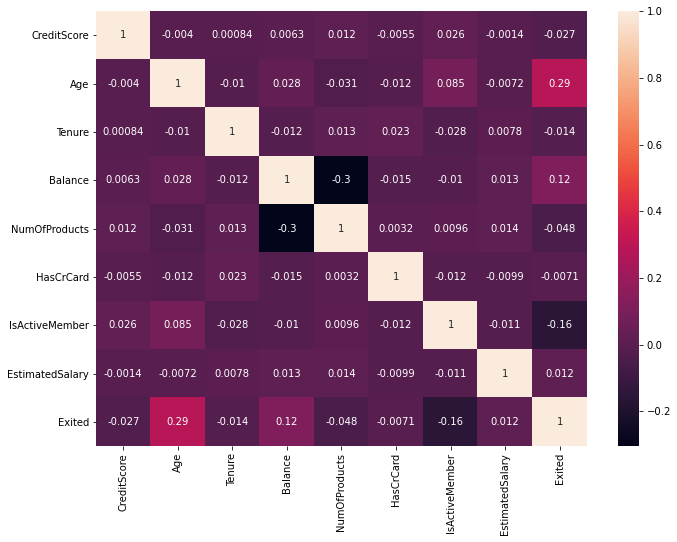

In [38]:
plt.subplots(figsize=(11,8))
sns.heatmap(df_abt_CustomerData.corr(), annot=True)
plt.show()

On the face of it, there is good separation of the independent variables as none are correlated - there is only a weak (-0.3) negative correlation between NumOfProduct and Balance. So, with the exception of the features that have been flagged above in the variable analysis as candidates for removal in feature selection, all the features will be taken into the model.

---
## Data Preparation
---

For the purposes of comparison, two datasets will be taken into model building. 

- Dataset #1 - All features
- Dataset #2 - Selected features (as per variable analysis above)

In [39]:
df_allfeatures_CustomerData = df_abt_CustomerData.copy()
df_selectedfeatures_CustomerData = df_abt_CustomerData.copy()

In [40]:
# Drop the features identified in variable analysis as candidates

df_selectedfeatures_CustomerData.drop(['Tenure', 'HasCrCard', 'EstimatedSalary'], axis=1, inplace=True)

In [41]:
# Prepare the X & Y sets for both datasets

X_all = df_allfeatures_CustomerData.drop(labels=['Exited'], axis=1)
Y_all = df_allfeatures_CustomerData.iloc[:, 10].values

X_selected = df_selectedfeatures_CustomerData.drop(labels=['Exited'], axis=1)
Y_selected = df_selectedfeatures_CustomerData.iloc[:, 7].values

In [42]:
# One-hot encode the categorical variables in both X sets

X_all = pd.get_dummies(X_all, columns=['Geography', 'Gender'], drop_first=True)
X_selected = pd.get_dummies(X_selected, columns=['Geography', 'Gender'], drop_first=True)

In [43]:
X_all.head()

CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619   42       2       0.00              1          1   
1          608   41       1   83807.86              1          0   
2          502   42       8  159660.80              3          1   
3          699   39       1       0.00              2          0   
4          850   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
0               1        101348.88                  0                0   
1               1        112542.58                  0                1   
2               0        113931.57                  0                0   
3               0         93826.63                  0                0   
4               1         79084.10                  0                1   

   Gender_Male  
0            0  
1            0  
2            0  
3            0  
4            0

In [44]:
X_selected.head()

CreditScore  Age    Balance  NumOfProducts  IsActiveMember  \
0          619   42       0.00              1               1   
1          608   41   83807.86              1               1   
2          502   42  159660.80              3               0   
3          699   39       0.00              2               0   
4          850   43  125510.82              1               1   

   Geography_Germany  Geography_Spain  Gender_Male  
0                  0                0            0  
1                  0                1            0  
2                  0                0            0  
3                  0                0            0  
4                  0                1            0

### Deliverable 4. Divide the data set into training and test sets
---

In [45]:
# Prepare the test and training sets for BOTH datasets
# This is a large dataset, so using a test/train split of 0.20

X_train_all, X_test_all, Y_train_all, Y_test_all = train_test_split(X_all, Y_all, test_size=0.20,random_state=1)
X_train_selected, X_test_selected, Y_train_selected, Y_test_selected = train_test_split(X_selected, Y_selected, test_size=0.20,random_state=1)

### Deliverable 5. Normalize the train and test data
---

In [46]:
# For the first pass of model building sklearn normalize is used to meet the requirements
# Scaling strategies is one of the options considered below for improving performance

X_train_all_normalized = preprocessing.normalize(X_train_all)
X_test_all_normalized = preprocessing.normalize(X_test_all)

X_train_selected_normalized = preprocessing.normalize(X_train_selected)
X_test_selected_normalized = preprocessing.normalize(X_test_selected)

---
## Model Building
---

### Deliverable 6. Initialize & build the model. Identify the points of improvement and implement the same the same.
---

The first step is to define a dataframe that will be used to capture the results of each pass at model building. Note that Recall is specifically targeted here as a metric. This is because the bank's objective is to predict customers who will churn, and direct efforts towards retaining them as customers. This means the cost of False Negatives is high - if the model predicts a customer will not churn and they do churn, the bank will lose them as a customer.

In [47]:
df_ModelComparison = pd.DataFrame(columns=['Model', 'Accuracy', 'Loss', 'Evaluation Accuracy', 'Evaluation Loss', 'Recall'])

In [48]:
# Define a function to draw confusion matrices

def draw_cm( actual, predicted ):
    cm = confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = [0,1] , yticklabels = [0,1] )
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()

#### Pass #1 - Simple model - comparing datasets

In [49]:
model_all = Sequential()

model_all.add(Dense(11,activation="relu"))
model_all.add(Dense(6,activation="relu"))
model_all.add(Dense(1,activation="sigmoid"))

model_all.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [50]:
history = model_all.fit(X_train_all_normalized, Y_train_all, batch_size = 10, epochs=50, verbose=0) 

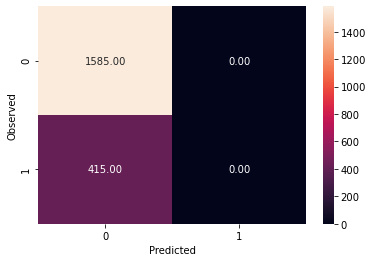

None


Model  Accuracy      Loss  Evaluation Accuracy  \
0  Pass 1 - Normalized All Features   0.79725  0.496459               0.7925   

   Evaluation Loss  Recall  
0         0.503399     0.0

In [51]:
# Evaluate the model against the test data
test_loss, test_acc = model_all.evaluate(X_test_all_normalized, Y_test_all, verbose=0)

# Get the accuracy and loss from the final epoch on the training data
accuracy = history.history['accuracy'][-1]
loss = history.history['loss'][-1]


y_predict = model_all.predict(X_test_all_normalized)
y_predict = (y_predict > 0.5)

print(draw_cm(Y_test_all, y_predict))

recall = round(recall_score(Y_test_all, y_predict), 5)
df_ModelComparison.loc[0] = ['Pass 1 - Normalized All Features', accuracy, loss, test_acc, test_loss, recall]
df_ModelComparison

In [52]:
# The second dataset has three fewer features, so adjust the architecture as required

model_selected = Sequential()

model_selected.add(Dense(8,activation="relu"))
model_selected.add(Dense(5,activation="relu"))
model_selected.add(Dense(1,activation="sigmoid"))

model_selected.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [53]:
history = model_selected.fit(X_train_selected_normalized, Y_train_selected, batch_size = 10, epochs=50, verbose=0) 

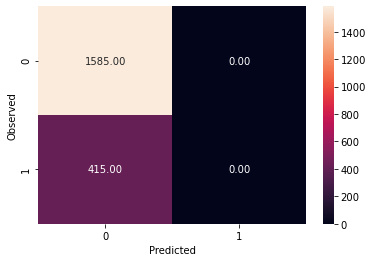

None


Model  Accuracy      Loss  \
0       Pass 1 - Normalized All Features   0.79725  0.496459   
1  Pass 1 - Normalized Selected Features   0.79725  0.504239   

   Evaluation Accuracy  Evaluation Loss  Recall  
0               0.7925         0.503399     0.0  
1               0.7925         0.510736     0.0

In [54]:
# Evaluate the model against the test data
test_loss, test_acc = model_selected.evaluate(X_test_selected_normalized, Y_test_selected, verbose=0)

# Get the accuracy and loss from the final epoch on the training data
accuracy = history.history['accuracy'][-1]
loss = history.history['loss'][-1]


y_predict = model_selected.predict(X_test_selected_normalized)
y_predict = (y_predict > 0.5)

print(draw_cm(Y_test_selected, y_predict))

recall = round(recall_score(Y_test_selected, y_predict), 5)
df_ModelComparison.loc[1] = ['Pass 1 - Normalized Selected Features', accuracy, loss, test_acc, test_loss, recall]
df_ModelComparison

#### Pass #2 - Scaling strategy

For either dataset, the models were not able to improve beyond 0.797, and the model trained with 'all features' failed to make any predictions of churn above 0.5 confidence. For this pass, the X data will instead be scaled with MinMaxScaler, to see if that improves the learning performance.

In [55]:
minmax = MinMaxScaler()

X_train_all_minmax = minmax.fit_transform(X_train_all)
X_test_all_minmax = minmax.transform(X_test_all)

X_train_selected_minmax = minmax.fit_transform(X_train_selected)
X_test_selected_minmax = minmax.transform(X_test_selected)

In [56]:
history = model_all.fit(X_train_all_minmax, Y_train_all, batch_size = 10, epochs=50, verbose=0) 

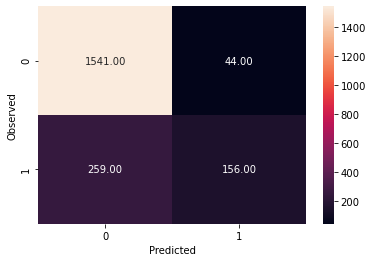

None


Model  Accuracy      Loss  \
0       Pass 1 - Normalized All Features   0.79725  0.496459   
1  Pass 1 - Normalized Selected Features   0.79725  0.504239   
2           Pass 2 - MinMax All Features   0.85100  0.353649   

   Evaluation Accuracy  Evaluation Loss  Recall  
0               0.7925         0.503399  0.0000  
1               0.7925         0.510736  0.0000  
2               0.8485         0.349219  0.3759

In [57]:
# Evaluate the model against the test data
test_loss, test_acc = model_all.evaluate(X_test_all_minmax, Y_test_all, verbose=0)

# Get the accuracy and loss from the final epoch on the training data
accuracy = history.history['accuracy'][-1]
loss = history.history['loss'][-1]


y_predict = model_all.predict(X_test_all_minmax)
y_predict = (y_predict > 0.5)

print(draw_cm(Y_test_all, y_predict))

recall = round(recall_score(Y_test_all, y_predict), 5)
df_ModelComparison.loc[2] = ['Pass 2 - MinMax All Features', accuracy, loss, test_acc, test_loss, recall]
df_ModelComparison

In [58]:
history = model_selected.fit(X_train_selected_minmax, Y_train_selected, batch_size = 10, epochs=50, verbose=0) 

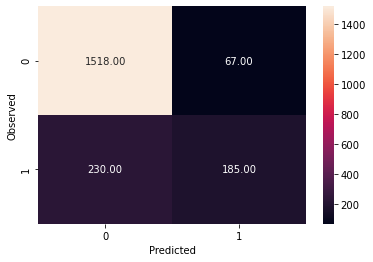

None


Model  Accuracy      Loss  \
0       Pass 1 - Normalized All Features   0.79725  0.496459   
1  Pass 1 - Normalized Selected Features   0.79725  0.504239   
2           Pass 2 - MinMax All Features   0.85100  0.353649   
3      Pass 2 - MinMax Selected Features   0.85225  0.355026   

   Evaluation Accuracy  Evaluation Loss   Recall  
0               0.7925         0.503399  0.00000  
1               0.7925         0.510736  0.00000  
2               0.8485         0.349219  0.37590  
3               0.8515         0.349971  0.44578

In [59]:
# Evaluate the model against the test data
test_loss, test_acc = model_selected.evaluate(X_test_selected_minmax, Y_test_selected, verbose=0)

# Get the accuracy and loss from the final epoch on the training data
accuracy = history.history['accuracy'][-1]
loss = history.history['loss'][-1]


y_predict = model_selected.predict(X_test_selected_minmax)
y_predict = (y_predict > 0.5)

print(draw_cm(Y_test_selected, y_predict))

recall = round(recall_score(Y_test_selected, y_predict), 5)
df_ModelComparison.loc[3] = ['Pass 2 - MinMax Selected Features', accuracy, loss, test_acc, test_loss, recall]
df_ModelComparison

The change of scaling strategy has significantly improved accuracy for both models. The dataset with all features scores higher on recall, and so will be taken into the next pass.

#### Pass #3 - Model architecture

In [60]:
model = Sequential()

model.add(Dense(11,activation="relu"))
model.add(Dense(5,activation="relu"))
model.add(Dense(2,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [61]:
history = model.fit(X_train_all_minmax, Y_train_all, batch_size = 10, epochs=50, verbose=0) 

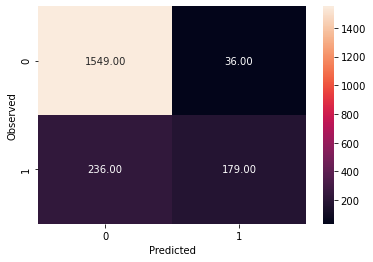

None


Model  Accuracy      Loss  \
0       Pass 1 - Normalized All Features   0.79725  0.496459   
1  Pass 1 - Normalized Selected Features   0.79725  0.504239   
2           Pass 2 - MinMax All Features   0.85100  0.353649   
3      Pass 2 - MinMax Selected Features   0.85225  0.355026   
4            Pass 3 - Model Architecture   0.86300  0.340020   

   Evaluation Accuracy  Evaluation Loss   Recall  
0               0.7925         0.503399  0.00000  
1               0.7925         0.510736  0.00000  
2               0.8485         0.349219  0.37590  
3               0.8515         0.349971  0.44578  
4               0.8640         0.337945  0.43133

In [62]:
# Evaluate the model against the test data
test_loss, test_acc = model.evaluate(X_test_all_minmax, Y_test_all, verbose=0)

# Get the accuracy and loss from the final epoch on the training data
accuracy = history.history['accuracy'][-1]
loss = history.history['loss'][-1]


y_predict = model.predict(X_test_all_minmax)
y_predict = (y_predict > 0.5)

print(draw_cm(Y_test_all, y_predict))

recall = round(recall_score(Y_test_all, y_predict), 5)
df_ModelComparison.loc[4] = ['Pass 3 - Model Architecture', accuracy, loss, test_acc, test_loss, recall]
df_ModelComparison

In [63]:
cr=metrics.classification_report(Y_test_all,y_predict)
print(cr)

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1585
           1       0.83      0.43      0.57       415

    accuracy                           0.86      2000
   macro avg       0.85      0.70      0.74      2000
weighted avg       0.86      0.86      0.85      2000



Adding an additional hidden layer has further improved accuracy and also improved recall, reducing the false negative predictions.

#### Pass #4 - Optimiser

In [64]:
model.compile(loss='binary_crossentropy',optimizer="sgd",metrics=['accuracy'])

In [65]:
history = model.fit(X_train_all_minmax, Y_train_all, batch_size = 10, epochs=50, verbose=0) 

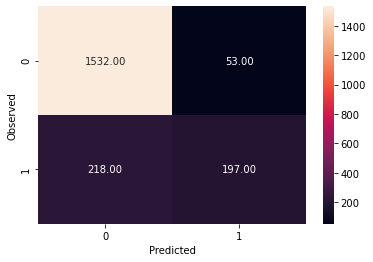

None


Model  Accuracy      Loss  \
0       Pass 1 - Normalized All Features   0.79725  0.496459   
1  Pass 1 - Normalized Selected Features   0.79725  0.504239   
2           Pass 2 - MinMax All Features   0.85100  0.353649   
3      Pass 2 - MinMax Selected Features   0.85225  0.355026   
4            Pass 3 - Model Architecture   0.86300  0.340020   
5                 Pass 4 - SGD Optimizer   0.86225  0.334696   

   Evaluation Accuracy  Evaluation Loss   Recall  
0               0.7925         0.503399  0.00000  
1               0.7925         0.510736  0.00000  
2               0.8485         0.349219  0.37590  
3               0.8515         0.349971  0.44578  
4               0.8640         0.337945  0.43133  
5               0.8645         0.333670  0.47470

In [66]:
# Evaluate the model against the test data
test_loss, test_acc = model.evaluate(X_test_all_minmax, Y_test_all, verbose=0)

# Get the accuracy and loss from the final epoch on the training data
accuracy = history.history['accuracy'][-1]
loss = history.history['loss'][-1]


y_predict = model.predict(X_test_all_minmax)
y_predict = (y_predict > 0.5)

print(draw_cm(Y_test_all, y_predict))

recall = round(recall_score(Y_test_all, y_predict), 5)
df_ModelComparison.loc[5] = ['Pass 4 - SGD Optimizer', accuracy, loss, test_acc, test_loss, recall]
df_ModelComparison

In [67]:
cr=metrics.classification_report(Y_test_all,y_predict)
print(cr)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1585
           1       0.79      0.47      0.59       415

    accuracy                           0.86      2000
   macro avg       0.83      0.72      0.76      2000
weighted avg       0.86      0.86      0.85      2000



Trying an alternative optimiser has reduced accuracy, but recall appears to have increased. For comparison, the adam optimiser will be taken into the next pass but with a learning rate schedule.

#### Pass #5 - Learning rate

Keras supports an option to lower the learning rate as training progresses, given an initial learning rate.

In [68]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=8000,
    decay_rate=0.9)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [69]:
history = model.fit(X_train_all_minmax, Y_train_all, batch_size = 10, epochs=50, verbose=0) 

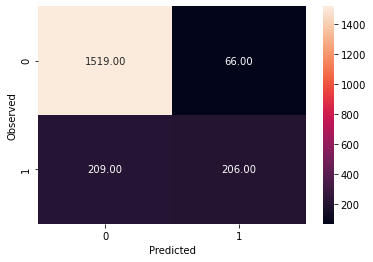

None


Model  Accuracy      Loss  \
0       Pass 1 - Normalized All Features   0.79725  0.496459   
1  Pass 1 - Normalized Selected Features   0.79725  0.504239   
2           Pass 2 - MinMax All Features   0.85100  0.353649   
3      Pass 2 - MinMax Selected Features   0.85225  0.355026   
4            Pass 3 - Model Architecture   0.86300  0.340020   
5                 Pass 4 - SGD Optimizer   0.86225  0.334696   
6                 Pass 5 - Learning rate   0.86575  0.326502   

   Evaluation Accuracy  Evaluation Loss   Recall  
0               0.7925         0.503399  0.00000  
1               0.7925         0.510736  0.00000  
2               0.8485         0.349219  0.37590  
3               0.8515         0.349971  0.44578  
4               0.8640         0.337945  0.43133  
5               0.8645         0.333670  0.47470  
6               0.8625         0.334821  0.49639

In [70]:
# Evaluate the model against the test data
test_loss, test_acc = model.evaluate(X_test_all_minmax, Y_test_all, verbose=0)

# Get the accuracy and loss from the final epoch on the training data
accuracy = history.history['accuracy'][-1]
loss = history.history['loss'][-1]


y_predict = model.predict(X_test_all_minmax)
y_predict = (y_predict > 0.5)

print(draw_cm(Y_test_all, y_predict))

recall = round(recall_score(Y_test_all, y_predict), 5)
df_ModelComparison.loc[6] = ['Pass 5 - Learning rate', accuracy, loss, test_acc, test_loss, recall]
df_ModelComparison

In [71]:
cr=metrics.classification_report(Y_test_all,y_predict)
print(cr)

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1585
           1       0.76      0.50      0.60       415

    accuracy                           0.86      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000



Changing the learning rate to use an exponential decay has had a negligible effect on the model accuracy but the recall has increased again, however the model has been built with only 50 epochs. The next strategy will be to increase the number of epochs to increase the learning rate change.

The next strategy is also to address the imbalance in the target variable. Keras allows a class_weight to be specified, using the technique applied below.

#### Pass #6 - Class weights & more epochs

In [72]:
weight_for_0 = 1.0 / 7963
weight_for_1 = 1.0 / 2037

class_weight = {0: weight_for_0, 1: weight_for_1}

In [73]:
history = model.fit(X_train_all_minmax, Y_train_all, batch_size = 10, epochs=200, verbose=0, class_weight=class_weight) 

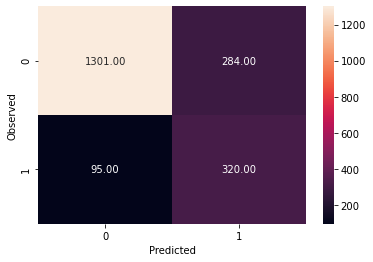

None


Model  Accuracy      Loss  \
0       Pass 1 - Normalized All Features  0.797250  0.496459   
1  Pass 1 - Normalized Selected Features  0.797250  0.504239   
2           Pass 2 - MinMax All Features  0.851000  0.353649   
3      Pass 2 - MinMax Selected Features  0.852250  0.355026   
4            Pass 3 - Model Architecture  0.863000  0.340020   
5                 Pass 4 - SGD Optimizer  0.862250  0.334696   
6                 Pass 5 - Learning rate  0.865750  0.326502   
7        Pass 6 - Class weights & epochs  0.803875  0.000087   

   Evaluation Accuracy  Evaluation Loss   Recall  
0               0.7925         0.503399  0.00000  
1               0.7925         0.510736  0.00000  
2               0.8485         0.349219  0.37590  
3               0.8515         0.349971  0.44578  
4               0.8640         0.337945  0.43133  
5               0.8645         0.333670  0.47470  
6               0.8625         0.334821  0.49639  
7               0.8105         0.439650  0.77108

In [74]:
# Evaluate the model against the test data
test_loss, test_acc = model.evaluate(X_test_all_minmax, Y_test_all, verbose=0)

# Get the accuracy and loss from the final epoch on the training data
accuracy = history.history['accuracy'][-1]
loss = history.history['loss'][-1]


y_predict = model.predict(X_test_all_minmax)
y_predict = (y_predict > 0.5)

print(draw_cm(Y_test_all, y_predict))

recall = round(recall_score(Y_test_all, y_predict), 5)
df_ModelComparison.loc[7] = ['Pass 6 - Class weights & epochs', accuracy, loss, test_acc, test_loss, recall]
df_ModelComparison

In [75]:
cr=metrics.classification_report(Y_test_all,y_predict)
print(cr)

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1585
           1       0.53      0.77      0.63       415

    accuracy                           0.81      2000
   macro avg       0.73      0.80      0.75      2000
weighted avg       0.85      0.81      0.82      2000



Using class weights as the strategy to address the imbalance in the target variable has drastically improved the recall score of the model. So, the final model for this analysis is using the full set of features, scaled with minmax scaler, using an architecture with two hidden layers, an exponentially decaying learning rate, and class weights.

---
## Prediction
---

### Deliverable 7. Predict the results using 0.5 as a threshold
---


In [76]:
y_predict = model.predict(X_test_all_minmax)
y_predict = (y_predict > 0.5)

### Deliverable 8. Print the Accuracy score and confusion matrix
---

In [77]:
df_FinalScore = df_ModelComparison.loc[[7]]
df_FinalScore

Model  Accuracy      Loss  Evaluation Accuracy  \
7  Pass 6 - Class weights & epochs  0.803875  0.000087               0.8105   

   Evaluation Loss   Recall  
7          0.43965  0.77108

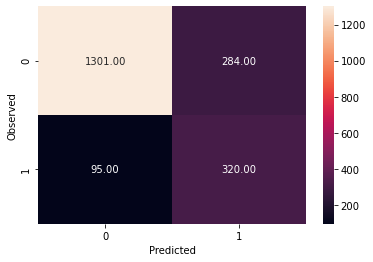

None


In [78]:
print(draw_cm(Y_test_all, y_predict))

---
## Conclusions
---

The final model produced a recall score of 0.771, correctly predicting 320 of the 415 churn customers.